# Single Graph Data Collection

## Imports

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pyvisa as visa
import struct 
import re
import time
import os

## Setup For Data Collection

In [57]:
# Make sure the directory ./data exists
if not os.path.exists("data"):
    os.makedirs("data")

# Delete all files in the directory ./data comment this line if you want to keep the files
# filelist = [ f for f in os.listdir("./data") if f.endswith(".txt") ]
# for f in filelist:
#     os.remove(os.path.join("./data", f))

## Get Data

In [58]:
# This will list the address of the spectrum analyzer if it is connected to the computer
visa.ResourceManager().list_resources() 

('ASRL4::INSTR', 'GPIB0::19::INSTR')

### Variables

In [59]:
# This determines the number of plots that will be taken (change as needed)
plots = 2;
# This determines the number of averages that will be taken (change as needed)
n_avgs = 6
# These determine the frequency range that will be plotted (change as needed)
decades_min = 2
decades = 7


all_data = []

In [60]:
#Function to Open connection
def set_fftconnect(key):
    rm = visa.ResourceManager()
    conn = rm.open_resource(key)
    conn.write_termination = chr(10)
    return conn

#byte reader function
def fft_byte_reader(arr):
    temp1 = re.findall(b'#[0-9]', arr)
    offset = int(temp1[0][1:])
    split_result = re.split(b'#[0-9]', arr, maxsplit = 1)[1]
    data = split_result[offset:-1]
    i = 1
    ret = []
    while i <= (len(data)/4):   
        fval = struct.unpack('>f', data[4*(i-1):(4*i)])
        ret.append(fval)
        i += 1
    return ret    

#byte reader function
def fft_byte_reader2(arr):
    temp1 = re.findall('#[0-9]', arr)
    offset = int(temp1[0][1:])
    split_result = re.split('#[0-9]', arr)[1]
    data = split_result[offset:-1]
    i = 1
    ret = []
    while i <= (len(data)/4):   
        fval = struct.unpack('>f', data[4*(i-1):(4*i)])
        ret.append(fval)
        i += 1
    return ret   

#Function to Get RF Range
def fft_set_range(conn, cent, span):
    conn.write("SENS:FREQ:CENT "+cent)
    conn.write("SENS:FREQ:SPAN "+span)

#function To Get PSD
def fft_getPSD(conn):
    conn.write("CONT")    
    print(f"Averaging {n_avgs}:", end=' ')
    while fft.query_ascii_values('SENS:AVER:COUNT:INT?')[0] < n_avgs:
        print(f"{fft.query_ascii_values('SENS:AVER:COUNT:INT?')[0]:.0f}", end=' ')
        time.sleep(3)
    conn.write(";:FORM REAL, 32;:CALC1:DATA?")
    rv = conn.read_raw()
    yaxis = fft_byte_reader(rv)
    conn.write(";:FORM ASC, 10")
    conn.write(";:FORM REAL, 32;:TRAC:X? TRAC1")
    rx = conn.read_raw()
    xaxis = fft_byte_reader(rx)
    conn.write(";:FORM ASC, 10")
    
    if len(xaxis) == 2049:
        xaxis=xaxis[0:1601]
    else:
        xaxis = xaxis[224:1825]
    
    t1 = np.matrix(xaxis)
    t2 = np.matrix(yaxis)
    print(f"Recvd PSD: X: {np.shape(t1)}, Y: {np.shape(t2)}", end=' ')
    t1 = t1.flatten()
    t1 = t1.transpose()
    t2 = t2.flatten() 
    t2 = t2.transpose()
    vals = np.array(np.hstack((t1,t2)))
    return vals

In [61]:
# Initialize the spectrum analyzer

# This is the address of the spectrum analyzer (you my need to change this)
fftkey = "GPIB0::19::INSTR"

rm = visa.ResourceManager()
fft = set_fftconnect(fftkey)
fft.write("INP1:COUP AC")
fft.write("INST:NSEL 3")
fft.write("CALC1:FEED 'XFR:POW:PSD 1'")
fft.write("CALC1:UNIT:POW Vrms/rtHz")
fft.write("SENS:FEED 'INPUT'")
fft.write("SENS:SWE1:POIN 1601")
fft.write("SENS:SWE1:MODE AUTO")
fft.write("CAL:AUTO OFF")
fft.write("CAL:ZERO:AUTO ONCE")
time.sleep(7)
fft.write("ABOR")
fft.close()
rm.close()

In [ ]:
#Data Collection

current_plot = 1;

while current_plot <= plots:

    plotName = input("Enter the name of the plot (can't contain &): ")
    plotName = plotName.replace("&", "")
    plotName = plotName.replace(" ", "_")
    print("----------- Plot " + str(current_plot) + "/" + str(plots) "-----------")

    rm = visa.ResourceManager()
    fft = set_fftconnect(fftkey)

    output = np.zeros((0,2))

    for j in range(decades_min, decades):
        #set max freq
        maxfreq = 10**(j + 1)
        minfreq = 10**j
        print(f"Working on {minfreq} to {maxfreq} Hz")
        fft.write("SENS:FREQUENCY:START " + str(minfreq))
        fft.write("SENS:FREQUENCY:STOP "  + str(maxfreq))
        fft.write('SENS:AVER:STATE OFF')
        time.sleep(1)
        fft.write('SENS:AVER:STATE ON')
        print(f"\tGetting PSD", end=' ')
        temp = fft_getPSD(fft)
        print("Shape of temp", np.shape(temp))
        if not 0 in np.shape(temp):
            output = np.append(output, temp, axis = 0)
    fft.write("ABOR")


    fft.close()
    rm.close()

    # Save the data to a file
    output.tofile("./data/" + str(current_plot) + "&" + str(plotName) + ".txt")
    print("Data saved to ./data/" + str(current_plot) + "&" + str(plotName) + ".txt")
    current_plot += 1

current_plot = plots


----------- Plot 1 -----------
Working on 100 to 1000 Hz
	Getting PSD Averaging 6: 0 2 4 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 1000 to 10000 Hz
	Getting PSD Averaging 6: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 10000 to 100000 Hz
	Getting PSD Averaging 6: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 100000 to 1000000 Hz
	Getting PSD Averaging 6: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 1000000 to 10000000 Hz
	Getting PSD Averaging 6: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Data saved to ./data/1&Noise Floor.txt
----------- Plot 2 -----------
Working on 100 to 1000 Hz
	Getting PSD Averaging 6: 0 2 4 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 1000 to 10000 Hz
	Getting PSD Averaging 6: 0 Recvd PSD: X: (1601, 1), Y: (1601, 1) Shape of temp (1601, 2)
Working on 10000 to 100000 Hz
	Getting PSD Averaging 6: 0

## Plot Data

{1: '1&Noise Floor.txt', 2: '2&Noise Floor With Cable.txt'}


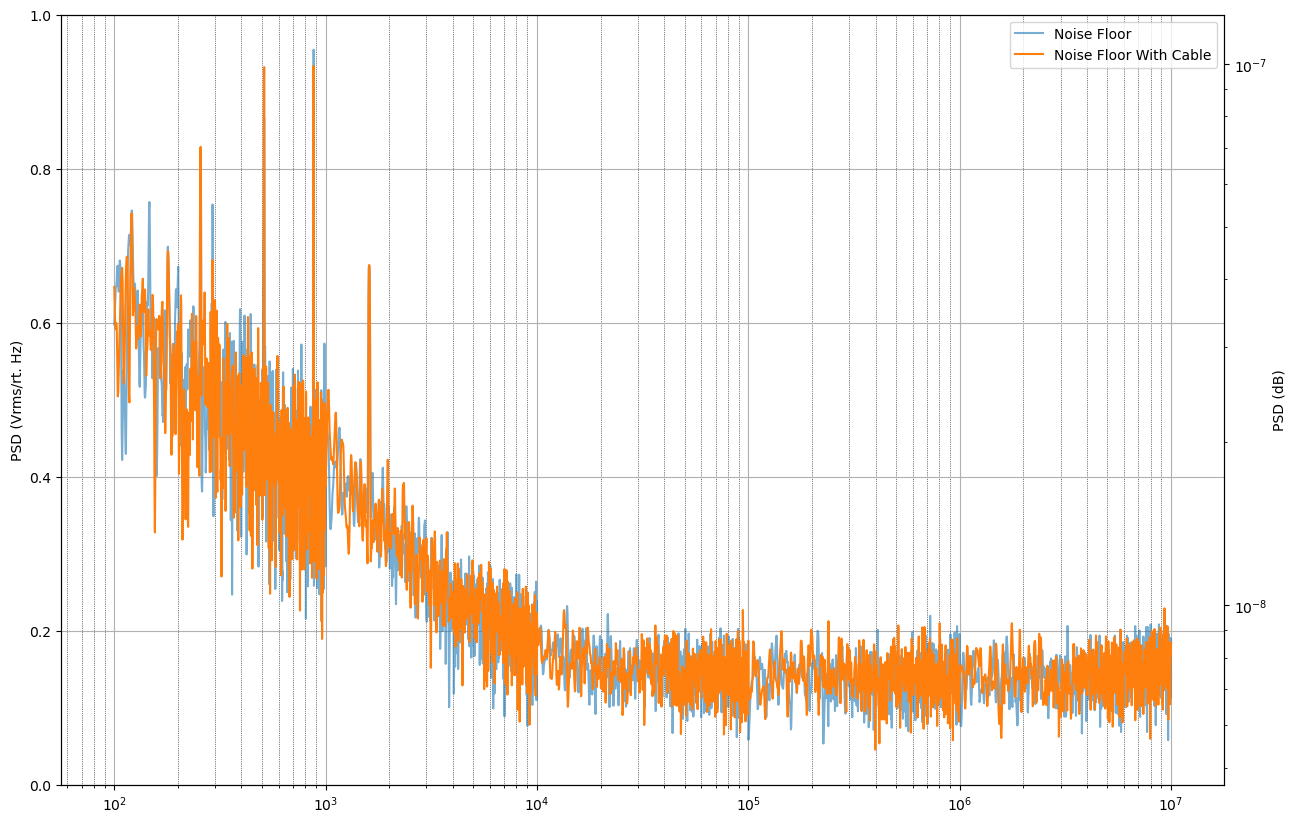

In [ ]:
# Create an array of all the data files by reading the directory ./data
files = {}
for file in os.listdir("./data"):
    if file.endswith(".txt"):
        if "&" in file:
            files[int(file.split("&")[0])] = file
print(files)

#Graphing
fig, ax = plt.subplots(figsize=[15, 10])
plt.grid()
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
ax.set(ylabel='PSD (Vrms/rt. Hz)')
ax2 = ax.twinx()
ax2.set(ylabel='PSD (dB)')
plt.xlabel("Frequency [Hz]")


for file in files:
    output = np.fromfile("./data/"+files[file])
    output = output.reshape(int(len(output)/2), 2)
    currentFileName=files[file].split("&")[1].split(".")[0].replace("_", " ")
    if currentFileName == "Noise Floor":
        plt.loglog(output[:,0],output[:,1], alpha=0.4 , label=currentFileName)
    else:
        plt.loglog(output[:,0],output[:,1], label=currentFileName)
    plt.legend()
    current_plot -= 1
plt.show()